In [31]:
import os # File system operations
import re # Regular expressions
import pandas as pd # Tabular data
import numpy as np # Numerical data
pd.set_option('display.max_colwidth', None) # Show full file paths

# Don't use all of the GPU RAM
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)
from tensorflow import keras # ML

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

from pathlib import Path # Pathing
from glob import glob # Finding files recursively
import matplotlib.pyplot as plt # Plotting
import seaborn as sns # Plotting
sns.set()
from tqdm.auto import tqdm # Progress bars
tqdm.pandas()

BASE_DIR = Path("EmbryoLabeling/Labelers/train")
folders = os.listdir(BASE_DIR)
folders = [f for f in folders if not re.match(r"M\d", f)]
files = []
for folder in folders:
    files_in_folder = pd.DataFrame(glob(f"{BASE_DIR}/{folder}/**/*.jpg", recursive=True), columns=["filename"])
    files_in_folder["class"] = folder
    files.append(files_in_folder)
df = pd.concat(files)
df["class"].value_counts()

Morula                 1319
2pn                    1039
Syngamy                 834
4 Cell                  792
2 Cell                  736
Compacting 8 cell       549
Expanded Blastocyst     394
8 Cell                  384
Blastocyst              374
6 Cell                  360
Cavitating morula       324
3 Cell                  303
Early blast             291
Name: class, dtype: int64

<AxesSubplot:>

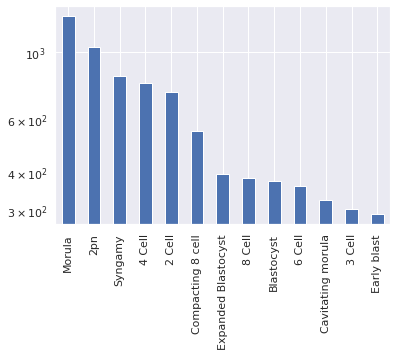

In [2]:
df["class"].value_counts().plot.bar(logy=True)

In [3]:
# Print counts of images by machine and slide
df.filename[~df["class"].isin(["bad", "Empty"])].apply(lambda s: s.split("/")[-1].split("_")[:2]).value_counts()

[M0776, S00512]    1896
[M776, S0087]      1520
[M0776, S00635]    1289
[M0776, S00761]    1111
[M0776, S00534]    1099
[M0776, S00470]     784
Name: filename, dtype: int64

In [4]:
# Track a single embryo's lifecycle
pd.set_option('display.max_rows', 365)
M776_S0087_W2 = df[df.filename.str.contains("M776_S0087_W2")].copy()
# Extract time since fertilisation in minutes from filename (ints, rounded to nearest minute)
M776_S0087_W2["time_since_fert"] = M776_S0087_W2.filename.apply(lambda s: s.replace(".jpg", "").split("_")[-1]).astype(int)
M776_S0087_W2 = M776_S0087_W2.sort_values(by="time_since_fert")
# Take the earliest time that each class was seen
M776_S0087_W2 = M776_S0087_W2.groupby("class").head(1)
print(M776_S0087_W2[["class", "time_since_fert"]])

                  class  time_since_fert
511                 2pn             1061
685             Syngamy             1464
298              2 Cell             1574
116              3 Cell             2315
104              4 Cell             2395
29               6 Cell             3125
145              8 Cell             3265
24    Compacting 8 cell             3375
1169             Morula             4286
199   Cavitating morula             5940
50          Early blast             6090
113          Blastocyst             6261


In [5]:
classes = list(M776_S0087_W2["class"])
classes

['2pn',
 'Syngamy',
 '2 Cell',
 '3 Cell',
 '4 Cell',
 '6 Cell',
 '8 Cell',
 'Compacting 8 cell',
 'Morula',
 'Cavitating morula',
 'Early blast',
 'Blastocyst']

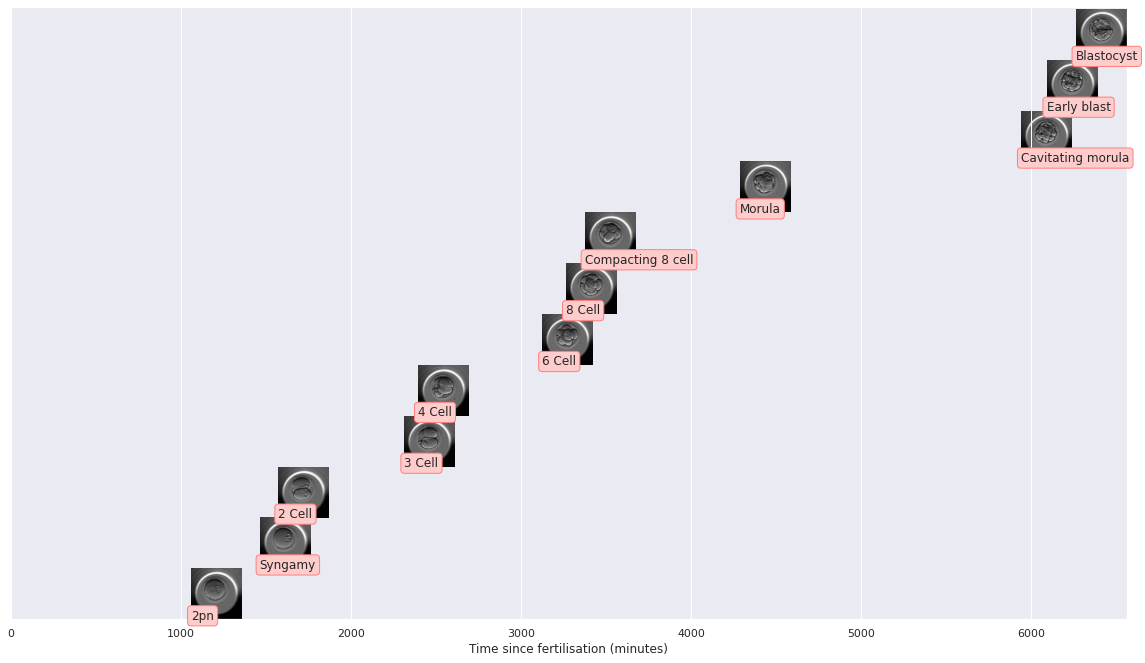

In [6]:
# Plot embryo's lifecycle over time
plt.figure(figsize=(20, 20))
for i, row in M776_S0087_W2.iterrows():
    image = keras.utils.load_img(row.filename, target_size=(299,299))
    c_index = classes.index(row["class"]) * 299
    time_since_fert = row.time_since_fert
    plt.imshow(image, extent=[time_since_fert, time_since_fert+299, c_index, c_index+299])
    plt.text(time_since_fert, c_index, row["class"], bbox=dict(boxstyle="round", ec=(1., 0.5, 0.5), fc=(1., 0.8, 0.8)))
plt.yticks([])
plt.xlabel("Time since fertilisation (minutes)")
plt.xlim(0, M776_S0087_W2.time_since_fert.max() + 300)
plt.ylim(0, len(classes) * 300)
plt.show()

In [7]:
class_counts = df["class"].value_counts()
mask = ~df["class"].isin(class_counts[class_counts > 10].index)
#df["class"][mask] = "Other"

In [8]:
#df["class"][~df["class"].isin(["Empty", "Morula"])] = "Other"
# Build training and validation dataframes. This gives us fine control over what we use for train & test
train_rows = []
validation_rows = []
for c in df["class"].unique():
    df_for_class = df[df["class"] == c].copy()
    if len(df_for_class) > 20:
        validation_sample = df_for_class.sample(round(.2*len(df_for_class)))
        validation_rows.append(validation_sample)
        train_sample = df_for_class.drop(validation_sample.index)
        # Accounting for training class imbalance
        # still leaving 20%. Might need more sophisticated f(x) here for class imbalance.
        train_sample = train_sample.sample(min(len(train_sample), round(.6*len(df_for_class))))
        train_rows.append(train_sample)
train_df = pd.concat(train_rows)
validation_df = pd.concat(validation_rows)
display(df)
display(train_df["class"].value_counts())
validation_df = validation_df.sample(frac=1)
display(validation_df["class"].value_counts())

,filename,class
0,EmbryoLabeling/Labelers/train/Expanded Blastocyst/M0776_S00512_W8_F0_6925.jpg,Expanded Blastocyst
1,EmbryoLabeling/Labelers/train/Expanded Blastocyst/M0776_S00534_W1_F0_7696.jpg,Expanded Blastocyst
2,EmbryoLabeling/Labelers/train/Expanded Blastocyst/M0776_S00761_W3_F0_6760.jpg,Expanded Blastocyst
3,EmbryoLabeling/Labelers/train/Expanded Blastocyst/M0776_S00512_W4_F0_6984.jpg,Expanded Blastocyst
4,EmbryoLabeling/Labelers/train/Expanded Blastocyst/M0776_S00761_W2_F0_6620.jpg,Expanded Blastocyst
...,...,...
731,EmbryoLabeling/Labelers/train/2 Cell/M0776_S00470_W3_F0_1654.jpg,2 Cell
732,EmbryoLabeling/Labelers/train/2 Cell/M0776_S00761_W1_F0_2267.jpg,2 Cell
733,EmbryoLabeling/Labelers/train/2 Cell/M776_S0087_W3_F0_1685.jpg,2 Cell
734,EmbryoLabeling/Labelers/train/2 Cell/M0776_S00470_W4_F0_1794.jpg,2 Cell


Morula                 791
2pn                    623
Syngamy                500
4 Cell                 475
2 Cell                 442
Compacting 8 cell      329
Expanded Blastocyst    236
8 Cell                 230
Blastocyst             224
6 Cell                 216
Cavitating morula      194
3 Cell                 182
Early blast            175
Name: class, dtype: int64

Morula                 264
2pn                    208
Syngamy                167
4 Cell                 158
2 Cell                 147
Compacting 8 cell      110
Expanded Blastocyst     79
8 Cell                  77
Blastocyst              75
6 Cell                  72
Cavitating morula       65
3 Cell                  61
Early blast             58
Name: class, dtype: int64

In [9]:
datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
training = datagen.flow_from_dataframe(train_df, target_size=(299, 299), batch_size=24, shuffle=True)
# Don't shuffle validation, otherwise confusion_matrix won't work due to mismatch
validation = datagen.flow_from_dataframe(validation_df, target_size=(299, 299), batch_size=24, shuffle=False)

Found 4617 validated image filenames belonging to 13 classes.
Found 1541 validated image filenames belonging to 13 classes.


In [10]:
assert training.class_indices == validation.class_indices

In [11]:
list(training.class_indices.keys())

['2 Cell',
 '2pn',
 '3 Cell',
 '4 Cell',
 '6 Cell',
 '8 Cell',
 'Blastocyst',
 'Cavitating morula',
 'Compacting 8 cell',
 'Early blast',
 'Expanded Blastocyst',
 'Morula',
 'Syngamy']

In [12]:
code2class = {v:k for k, v in training.class_indices.items()}
code2class

{0: '2 Cell',
 1: '2pn',
 2: '3 Cell',
 3: '4 Cell',
 4: '6 Cell',
 5: '8 Cell',
 6: 'Blastocyst',
 7: 'Cavitating morula',
 8: 'Compacting 8 cell',
 9: 'Early blast',
 10: 'Expanded Blastocyst',
 11: 'Morula',
 12: 'Syngamy'}

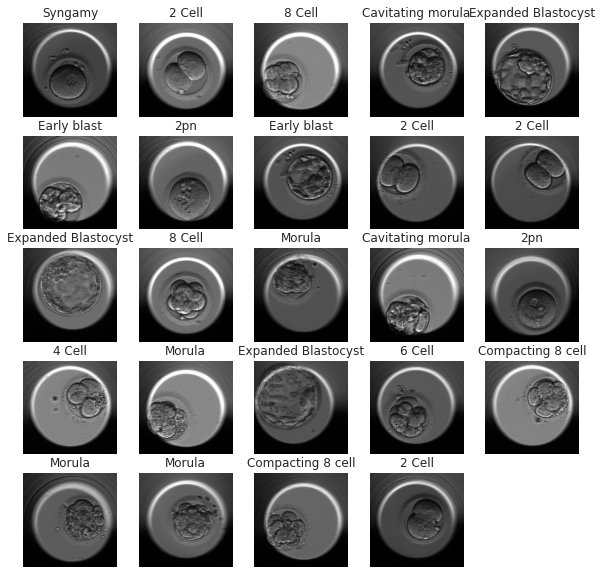

In [13]:
plt.figure(figsize=(10, 10))
images, labels = next(training)
for i in range(24):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(images[i])
    plt.title(code2class[labels[i].argmax()])
    plt.axis("off")

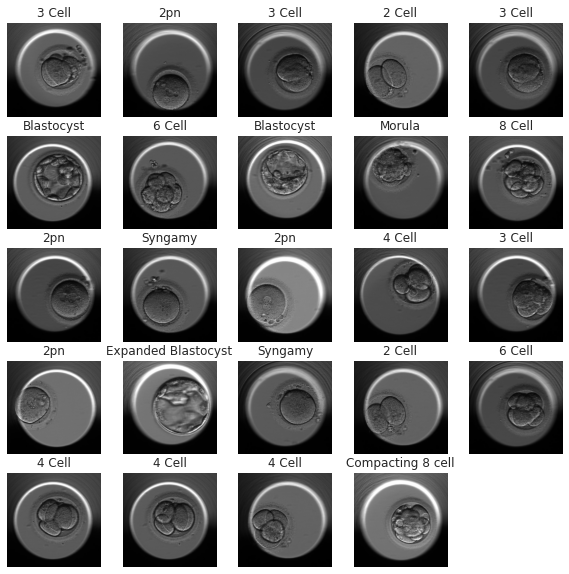

In [14]:
plt.figure(figsize=(10, 10))
images, labels = next(validation)
for i in range(min(24, len(labels))):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(images[i])
    plt.title(code2class[labels[i].argmax()])
    plt.axis("off")

In [15]:
base_model = keras.applications.Xception(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(299, 299, 3),
    include_top=False)  # Do not include the ImageNet classifier at the top.

# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(299, 299, 3))

# Pre-trained Xception weights requires that input be scaled
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
scale_layer = keras.layers.Rescaling(scale=2, offset=-1)
x = scale_layer(inputs)

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
#x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(len(code2class), activation='softmax')(x)
model = keras.Model(inputs, outputs)

model.summary()

2022-05-25 08:36:45.472815: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-25 08:36:45.474004: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-25 08:36:45.474264: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-25 08:36:45.474401: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 299, 299, 3)       0         
                                                                 
 xception (Functional)       (None, 10, 10, 2048)      20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 13)                26637     
                                                                 
Total params: 20,888,117
Trainable params: 26,637
Non-trainable params: 20,861,480
____________________________________________

In [16]:
%%time
training.reset()
validation.reset()
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=[keras.metrics.CategoricalAccuracy()],
)

history = model.fit(training, epochs=60, validation_data=validation)

Epoch 1/60


2022-05-25 08:36:51.323010: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8302
2022-05-25 08:36:52.102528: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


193/193 [==============================] - 86s 423ms/step - loss: 1.6748 - categorical_accuracy: 0.4715 - val_loss: 1.3504 - val_categorical_accuracy: 0.5373
Epoch 2/60
193/193 [==============================] - 19s 98ms/step - loss: 1.1487 - categorical_accuracy: 0.6376 - val_loss: 1.0681 - val_categorical_accuracy: 0.6632
Epoch 3/60
193/193 [==============================] - 19s 98ms/step - loss: 0.9582 - categorical_accuracy: 0.7028 - val_loss: 0.9375 - val_categorical_accuracy: 0.7086
Epoch 4/60
193/193 [==============================] - 19s 99ms/step - loss: 0.8296 - categorical_accuracy: 0.7416 - val_loss: 0.8712 - val_categorical_accuracy: 0.7210
Epoch 5/60
193/193 [==============================] - 19s 98ms/step - loss: 0.7534 - categorical_accuracy: 0.7719 - val_loss: 0.8136 - val_categorical_accuracy: 0.7177
Epoch 6/60
193/193 [==============================] - 19s 96ms/step - loss: 0.6883 - categorical_accuracy: 0.7927 - val_loss: 0.7475 - val_categorical_accuracy: 0.7567
Ep

193/193 [==============================] - 18s 96ms/step - loss: 0.1628 - categorical_accuracy: 0.9653 - val_loss: 0.3578 - val_categorical_accuracy: 0.8825
Epoch 50/60
193/193 [==============================] - 19s 96ms/step - loss: 0.1568 - categorical_accuracy: 0.9682 - val_loss: 0.3544 - val_categorical_accuracy: 0.8741
Epoch 51/60
193/193 [==============================] - 19s 97ms/step - loss: 0.1575 - categorical_accuracy: 0.9640 - val_loss: 0.3500 - val_categorical_accuracy: 0.8851
Epoch 52/60
193/193 [==============================] - 19s 95ms/step - loss: 0.1536 - categorical_accuracy: 0.9679 - val_loss: 0.3443 - val_categorical_accuracy: 0.8864
Epoch 53/60
193/193 [==============================] - 19s 98ms/step - loss: 0.1514 - categorical_accuracy: 0.9690 - val_loss: 0.3534 - val_categorical_accuracy: 0.8806
Epoch 54/60
193/193 [==============================] - 18s 94ms/step - loss: 0.1477 - categorical_accuracy: 0.9679 - val_loss: 0.3489 - val_categorical_accuracy: 0.881

<AxesSubplot:>

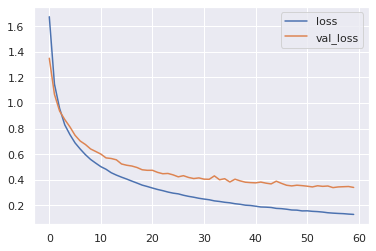

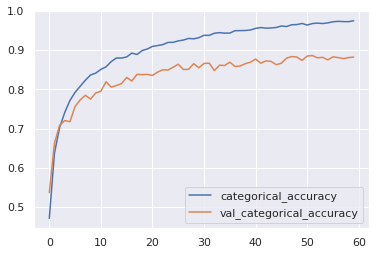

In [17]:
history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()
history_df[['categorical_accuracy', 'val_categorical_accuracy']].plot()

In [18]:
validation.reset()
print("True:", validation.labels)
print("Predictions: ", model.predict(validation).argmax(axis=1))

True: [2, 1, 2, 0, 2, 6, 4, 6, 11, 5, 1, 12, 1, 3, 2, 1, 10, 12, 0, 4, 3, 3, 3, 8, 2, 2, 8, 11, 0, 3, 3, 3, 10, 10, 11, 7, 0, 8, 8, 11, 12, 11, 0, 6, 7, 0, 2, 4, 4, 3, 0, 0, 5, 11, 11, 5, 6, 3, 1, 11, 0, 4, 12, 11, 0, 3, 4, 0, 0, 12, 1, 0, 2, 12, 8, 3, 11, 11, 10, 4, 1, 11, 12, 12, 3, 4, 12, 0, 11, 11, 3, 1, 0, 11, 7, 5, 6, 11, 4, 12, 0, 11, 6, 1, 11, 11, 8, 1, 9, 1, 3, 8, 2, 11, 1, 5, 1, 11, 3, 12, 11, 0, 11, 2, 10, 11, 11, 12, 9, 9, 2, 6, 8, 3, 0, 0, 12, 3, 0, 5, 6, 1, 12, 9, 12, 5, 3, 11, 0, 3, 11, 0, 11, 8, 0, 10, 0, 1, 2, 11, 8, 9, 11, 12, 0, 4, 0, 6, 8, 10, 11, 7, 3, 1, 6, 4, 3, 1, 10, 0, 8, 3, 4, 11, 4, 0, 8, 3, 2, 7, 8, 10, 11, 9, 1, 9, 11, 4, 11, 5, 12, 11, 3, 8, 12, 1, 11, 12, 1, 0, 8, 5, 0, 12, 5, 6, 3, 11, 3, 1, 12, 3, 0, 5, 0, 4, 1, 11, 2, 2, 9, 11, 12, 1, 9, 8, 3, 7, 12, 5, 1, 11, 11, 0, 1, 3, 11, 12, 1, 1, 11, 0, 0, 12, 3, 0, 10, 5, 9, 12, 11, 3, 6, 6, 3, 11, 11, 12, 10, 3, 7, 11, 2, 8, 7, 2, 4, 9, 1, 3, 10, 3, 12, 12, 2, 8, 3, 1, 12, 0, 10, 11, 3, 4, 0, 0, 6, 1, 4, 0, 7

In [41]:
y_pred = model.predict(validation)

In [55]:
predicted_codes = y_pred.argmax(axis=1)
confidence = pd.Series(y_pred.max(axis=1))
confidence.describe()

count    1541.000000
mean        0.870207
std         0.159664
min         0.236823
25%         0.796567
50%         0.944968
75%         0.989195
max         0.999994
dtype: float64

In [58]:
validation_df["predicted_class"] = [code2class[c] for c in predicted_codes]
validation_df["confidence"] = confidence
validation_df

,filename,class,predicted_class,confidence
243,EmbryoLabeling/Labelers/train/3 Cell/M0776_S00512_W8_F0_1960.jpg,3 Cell,3 Cell,0.993885
113,EmbryoLabeling/Labelers/train/2pn/M0776_S00470_W6_F0_887.jpg,2pn,2pn,0.990539
259,EmbryoLabeling/Labelers/train/3 Cell/M0776_S00470_W3_F0_1814.jpg,3 Cell,3 Cell,0.991375
342,EmbryoLabeling/Labelers/train/2 Cell/M0776_S00534_W4_F0_2036.jpg,2 Cell,2 Cell,0.589549
182,EmbryoLabeling/Labelers/train/3 Cell/M0776_S00470_W3_F0_1964.jpg,3 Cell,3 Cell,0.385609
...,...,...,...,...
586,EmbryoLabeling/Labelers/train/Syngamy/M0776_S00470_W1_F0_1126.jpg,Syngamy,Syngamy,0.475511
699,EmbryoLabeling/Labelers/train/2 Cell/M0776_S00512_W1_F0_2149.jpg,2 Cell,2 Cell,0.980338
72,EmbryoLabeling/Labelers/train/Early blast/M0776_S00512_W1_F0_5900.jpg,Early blast,Early blast,0.930983
713,EmbryoLabeling/Labelers/train/Morula/M776_S0087_W2_F0_4896.jpg,Morula,Morula,0.813969


In [71]:
validation_df.groupby("class").confidence.median()

class
2 Cell                 0.936364
2pn                    0.946940
3 Cell                 0.958187
4 Cell                 0.945946
6 Cell                 0.922930
8 Cell                 0.925397
Blastocyst             0.936213
Cavitating morula      0.923705
Compacting 8 cell      0.918511
Early blast            0.944074
Expanded Blastocyst    0.926782
Morula                 0.949989
Syngamy                0.927243
Name: confidence, dtype: float32

In [59]:
validation_df.to_csv("validation_predictions.csv", index=False)

                     precision    recall  f1-score   support

             2 Cell       0.94      0.95      0.95       147
                2pn       0.94      0.96      0.95       208
             3 Cell       0.87      0.85      0.86        61
             4 Cell       0.95      0.94      0.95       158
             6 Cell       0.94      0.69      0.80        72
             8 Cell       0.86      0.83      0.85        77
         Blastocyst       0.78      0.83      0.80        75
  Cavitating morula       0.81      0.72      0.76        65
  Compacting 8 cell       0.79      0.75      0.77       110
        Early blast       0.88      0.66      0.75        58
Expanded Blastocyst       0.88      0.87      0.88        79
             Morula       0.82      0.95      0.88       264
            Syngamy       0.94      0.93      0.93       167

           accuracy                           0.88      1541
          macro avg       0.88      0.84      0.86      1541
       weighted avg   

Text(30.499999999999993, 0.5, 'True')

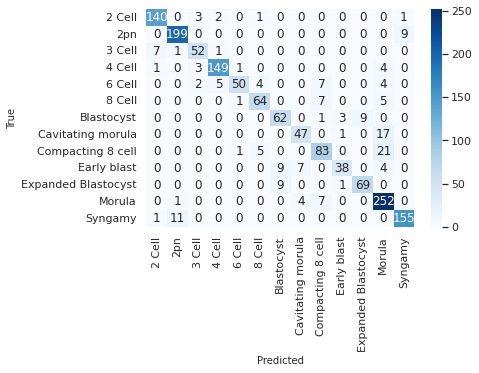

In [63]:
print(classification_report(validation_df["class"], validation_df["predicted_class"]))
labels = list(training.class_indices.keys())
s = sns.heatmap(
    confusion_matrix(validation_df["class"], validation_df["predicted_class"]),
    annot=True,
    cmap='Blues',
    fmt="g",
    xticklabels=labels,
    yticklabels=labels
)
s.set_xlabel('Predicted', fontsize=10)
s.set_ylabel('True', fontsize=10)

In [20]:
model.save(f"models/{len(code2class)}_class.h5")

In [24]:
# Make some predictions on unlabelled data
folders = os.listdir("EmbryoLabeling/Labelers/One")
folders = [f for f in folders if re.match(r"M\d", f)]
files = []
for folder in folders:
    files_in_folder = pd.DataFrame(glob(f"EmbryoLabeling/Labelers/One/{folder}/**/*.jpg", recursive=True), columns=["filename"])
    files_in_folder["class"] = "unknown"
    files.append(files_in_folder)
test_df = pd.concat(files)
test_df

,filename,class
0,EmbryoLabeling/Labelers/One/M3169_S00470/M3169_S00470_W1_F0_1516.jpg,unknown
1,EmbryoLabeling/Labelers/One/M3169_S00470/M3169_S00470_W7_F0_9023.jpg,unknown
2,EmbryoLabeling/Labelers/One/M3169_S00470/M3169_S00470_W4_F0_9524.jpg,unknown
3,EmbryoLabeling/Labelers/One/M3169_S00470/M3169_S00470_W2_F0_8369.jpg,unknown
4,EmbryoLabeling/Labelers/One/M3169_S00470/M3169_S00470_W7_F0_9589.jpg,unknown
...,...,...
4046,EmbryoLabeling/Labelers/One/M0831_S00534/M0831_S00534_W12_F0_998.jpg,unknown
4047,EmbryoLabeling/Labelers/One/M0831_S00534/M0831_S00534_W5_F0_3216.jpg,unknown
4048,EmbryoLabeling/Labelers/One/M0831_S00534/M0831_S00534_W12_F0_4793.jpg,unknown
4049,EmbryoLabeling/Labelers/One/M0831_S00534/M0831_S00534_W3_F0_3916.jpg,unknown


In [72]:
class TQDMPredictCallback(keras.callbacks.Callback):
    def __init__(self, custom_tqdm_instance=None, tqdm_cls=tqdm, **tqdm_params):
        super().__init__()
        self.tqdm_cls = tqdm_cls
        self.tqdm_progress = None
        self.prev_predict_batch = None
        self.custom_tqdm_instance = custom_tqdm_instance
        self.tqdm_params = tqdm_params

    def on_predict_batch_begin(self, batch, logs=None):
        pass

    def on_predict_batch_end(self, batch, logs=None):
        self.tqdm_progress.update(batch - self.prev_predict_batch)
        self.prev_predict_batch = batch

    def on_predict_begin(self, logs=None):
        self.prev_predict_batch = 0
        if self.custom_tqdm_instance:
            self.tqdm_progress = self.custom_tqdm_instance
            return

        total = self.params.get('steps')
        if total:
            total -= 1

        self.tqdm_progress = self.tqdm_cls(total=total, **self.tqdm_params)

    def on_predict_end(self, logs=None):
        if self.tqdm_progress and not self.custom_tqdm_instance:
            self.tqdm_progress.close()

test = datagen.flow_from_dataframe(test_df, target_size=(299, 299), batch_size=24, shuffle=False)
results = model.predict(test, callbacks=[TQDMPredictCallback()])

Found 26557 validated image filenames belonging to 13 classes.


  0%|          | 0/1106 [00:00<?, ?it/s]

In [74]:
predicted_codes = results.argmax(axis=1)
confidence = pd.Series(results.max(axis=1))
confidence.describe()

count    26557.000000
mean         0.766926
std          0.202555
min          0.180772
25%          0.600938
50%          0.816797
75%          0.954611
max          0.999999
dtype: float64

In [75]:
test_df["class"] = [code2class[c] for c in predicted_codes]
test_df["confidence"] = confidence

In [76]:
test_df["class"].value_counts()

2pn                    9724
Morula                 4885
Expanded Blastocyst    2544
Syngamy                2439
Compacting 8 cell      1941
4 Cell                 1531
Blastocyst             1056
2 Cell                 1010
Cavitating morula       750
Early blast             272
8 Cell                  212
3 Cell                  135
6 Cell                   58
Name: class, dtype: int64

In [77]:
test_df

,filename,class,confidence
0,EmbryoLabeling/Labelers/One/M3169_S00470/M3169_S00470_W1_F0_1516.jpg,2pn,0.715905
1,EmbryoLabeling/Labelers/One/M3169_S00470/M3169_S00470_W7_F0_9023.jpg,2pn,0.729338
2,EmbryoLabeling/Labelers/One/M3169_S00470/M3169_S00470_W4_F0_9524.jpg,Expanded Blastocyst,0.509856
3,EmbryoLabeling/Labelers/One/M3169_S00470/M3169_S00470_W2_F0_8369.jpg,4 Cell,0.817819
4,EmbryoLabeling/Labelers/One/M3169_S00470/M3169_S00470_W7_F0_9589.jpg,Morula,0.539923
...,...,...,...
4046,EmbryoLabeling/Labelers/One/M0831_S00534/M0831_S00534_W12_F0_998.jpg,2pn,0.668380
4047,EmbryoLabeling/Labelers/One/M0831_S00534/M0831_S00534_W5_F0_3216.jpg,8 Cell,0.561936
4048,EmbryoLabeling/Labelers/One/M0831_S00534/M0831_S00534_W12_F0_4793.jpg,Morula,0.996457
4049,EmbryoLabeling/Labelers/One/M0831_S00534/M0831_S00534_W3_F0_3916.jpg,Compacting 8 cell,0.468933


In [78]:
test_df.to_csv("predictions.csv", index=False)